In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from cmcrameri import cm
# from statsmodels.formula.api import ols
from scipy.special import ndtr
from scipy.optimize import curve_fit, differential_evolution
# from scipy.stats import linregress, ttest_rel, spearmanr, shapiro, sem
# from pathlib import Path
from math import sqrt
# from math import log, e

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

Code to visualzie metrics dataframe and draw psychometric curves of experiments.

Conditions for this notebook to run without problems:
- each folder in the experiment folder contains the results of the single model ("..._metrics.csv" and "..._fraction_correct.csv");
- the \data and the \plots folders have the same sub-folder names, that correspond to different experiments performed.

# Fitting parameters function:

In [2]:
# defining the sigmoid function to fit to the data:
def sigmoid(k, k0, delta):
    return (1+ndtr((k-k0)/delta))/2

# defining the function to calculate fitted parameters for all models:
def calculate_fitted_params(exp_name):
    # go to exp folder:
    folder_path = os.path.join('..','results', 'data', exp_name)
    fitted_params_df = pd.DataFrame()  # create an empty dataframe for recap
    # loop over all folders in the experiment folder (each folder corresponds to a model)
    for folder_name in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, folder_name)):
            file_path = os.path.join(folder_path, folder_name, f'{folder_name}_N224_fraction_correct.csv')
            if os.path.isfile(file_path):
                df_fraction_correct = pd.read_csv(file_path)
                fitted_values = [curve_fit(sigmoid, df_fraction_correct['clique size'], df_fraction_correct['fraction correct'], p0=(70, 20))[0]]
                fitted_params_model = pd.DataFrame(fitted_values, columns=['k0', 'delta'])
                fitted_params_model['model'] = folder_name
                fitted_params_df = pd.concat([fitted_params_df, fitted_params_model], ignore_index=True)

    return fitted_params_df

# example of use:
fitted_params_df = calculate_fitted_params('2024-09-04_all-steps')
fitted_params_df

,k0,delta,model
0,54.324465,4.228279,CNN_large_1
1,35.072352,5.304094,CNN_large_2
2,46.495976,11.907588,CNN_medium_1
3,38.608336,5.112600,CNN_medium_2
4,459.904331,165.697789,CNN_rudy
5,56.917781,11.552355,CNN_small_1
6,51.785988,9.419434,CNN_small_2
7,51.713198,17.389151,GoogLeNetpretrained
8,35.057394,5.588939,GoogLeNetscratch
9,57.504653,9.540178,MLP


# Metrics summary:

In [3]:
def summarize_exp_metrics(exp_name):
    
    # calculate fitted params for all models:
    fitted_params_df = calculate_fitted_params(exp_name)
        
    # go to exp folder:
    folder_path = os.path.join('..','results', 'data', exp_name)
    metrics_summary_df = pd.DataFrame()  # create an empty dataframe for recap
    # loop over all folders in the experiment folder (each folder corresponds to a model)
    for folder_name in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, folder_name)):
            file_path = os.path.join(folder_path, folder_name, f'{folder_name}_N224_metrics.csv')
            if os.path.isfile(file_path):
                df_metrics = pd.read_csv(file_path)
                df_metrics['model'] = folder_name
                df_metrics['k0'] = fitted_params_df.loc[fitted_params_df['model'] == folder_name, 'k0'].values[0]
                metrics_summary_df = pd.concat([metrics_summary_df, df_metrics], ignore_index=True)
                        
    # write k0 column in decimal notation:
    metrics_summary_df['k0'] = metrics_summary_df['k0'].apply(lambda x: '{:.2f}'.format(x))
    # rounding all values to 2 decimal places:
    metrics_summary_df = metrics_summary_df.round(2)
    # place the 'model' column at the beginning of the dataframe:
    cols = metrics_summary_df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    metrics_summary_df = metrics_summary_df[cols]

    return metrics_summary_df

# example of use:
metrics_summary_df = summarize_exp_metrics('2024-09-04_all-steps')
metrics_summary_df

,model,k0,TP,FP,TN,FN,precision,recall,F1,AUC_ROC
0,CNN_large_1,54.32,18960,0,28692,9948,1.00,0.66,0.79,0.92
1,CNN_large_2,35.07,22264,166,28756,6414,0.99,0.78,0.87,0.92
2,CNN_medium_1,46.50,21400,2737,26127,7336,0.89,0.74,0.81,0.88
3,CNN_medium_2,38.61,21736,30,28781,7053,1.00,0.76,0.86,0.92
4,CNN_rudy,459.90,28078,27742,1105,675,0.50,0.98,0.66,0.64
5,CNN_small_1,56.92,18509,577,28407,10107,0.97,0.65,0.78,0.86
6,CNN_small_2,51.79,19308,265,28628,9399,0.99,0.67,0.80,0.88
7,GoogLeNetpretrained,51.71,21472,4069,24575,7484,0.84,0.74,0.79,0.86
8,GoogLeNetscratch,35.06,22359,178,28771,6292,0.99,0.78,0.87,0.92
9,MLP,57.50,18204,50,28894,10452,1.00,0.64,0.78,0.88


# Drawing psychometrics:

In [4]:
# setting color palette

import colorcet as cc

# Define names of all models
model_names = ['MLP', 'CNN_small_1', 'CNN_small_2', 'CNN_medium_1', 'CNN_medium_2', 'CNN_large_1', 'CNN_large_2', 'CNN_rudy', 'VGG16scratch', 'ResNet50scratch', 'GoogLeNetscratch', 'ViTscratch', 'VGG16pretrained', 'ResNet50pretrained', 'GoogLeNetpretrained', 'ViTpretrained']  

# Associate a color to each group of models:
# - MLP:
my_palette_MLP = sns.color_palette(cc.glasbey, len(model_names))[0]
# - CNNs:
my_palette_CNN = sns.color_palette(cc.glasbey, len(model_names))[1:8]
# - Scratch models:
my_palette_scratch = sns.color_palette(cc.glasbey, len(model_names))[8:12]
# - Pretrained models:
my_palette_pretrained = sns.color_palette(cc.glasbey, len(model_names))[12:16]


# defining custom palette:
my_palette = {
    'MLP': my_palette_MLP,
    'CNN_small_1': my_palette_CNN[0],
    'CNN_small_2': my_palette_CNN[1],
    'CNN_medium_1' : my_palette_CNN[2],
    'CNN_medium_2' : my_palette_CNN[3],
    'CNN_large_1' : my_palette_CNN[4],
    'CNN_large_2' : my_palette_CNN[5],
    'CNN_rudy' : my_palette_CNN[6],
    'VGG16scratch': my_palette_scratch[0],
    'ResNet50scratch': my_palette_scratch[1],
    'GoogLeNetscratch': my_palette_scratch[2],
    'ViTscratch': my_palette_scratch[3],
    'VGG16pretrained': my_palette_pretrained[0],
    'ResNet50pretrained': my_palette_pretrained[1],
    'GoogLeNetpretrained': my_palette_pretrained[2],
    'ViTpretrained': my_palette_pretrained[3]    
}

## All models

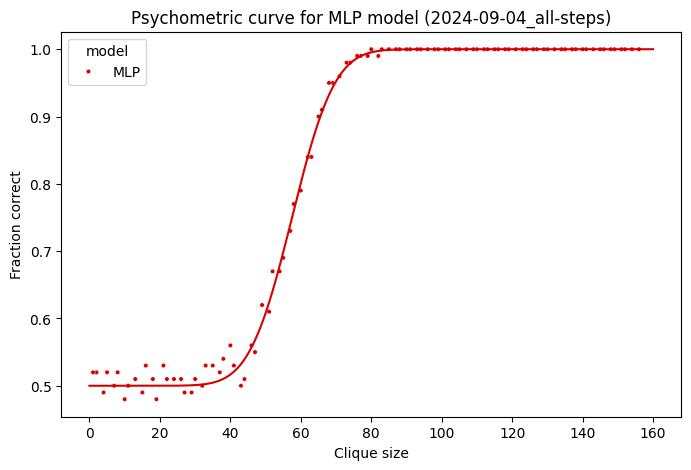

In [8]:
def draw_all_psychometrics(exp_name, model_type, my_palette=my_palette):
    """
    Draw and save psychometric curves for all instances of specified models in the requested experiment.

    Parameters:
    exp_name (str): The name of the experiment.
    model_type (str): The type of model to consider. Valid values are 'MLP', 'CNNs', 'scratch', 'pretrained'.
    my_palette (dict): A dictionary associating a color to each model type.

    Returns:
    None
    """
    # testing that model_type is valid
    if model_type not in ['MLP', 'CNN', 'scratch', 'pretrained']:
        raise ValueError("model_type must be one of 'MLP', 'CNN', 'scratch', 'pretrained'")
    
    # RETRIEVING THE DATA
    # - go to exp folder:
    folder_path = os.path.join('..','results', 'data', exp_name)
    # - isolate the folders corresponding to the specified model type
    filtered_folders = [folder_name for folder_name in os.listdir(folder_path) if model_type in folder_name]
    results_df = pd.DataFrame()
    models_names = []
    for folder_name in filtered_folders:
        models_names.append(folder_name)
        file_path = os.path.join(folder_path, folder_name, f'{folder_name}_N224_fraction_correct.csv')
        if os.path.isfile(file_path):
            df_result = pd.read_csv(file_path)
            df_result['model'] = folder_name
            results_df = pd.concat([results_df, df_result], ignore_index=True)

    # FITTING THE DATA
    all_fitted_params = calculate_fitted_params(exp_name)
    # - filtering the fitted parameters to keep only the ones corresponding to the specified model type
    fitted_params_df = all_fitted_params[all_fitted_params['model'].str.contains(model_type)]
    
    # SELECTING THE RIGHT PALETTE
    my_palette_filtered = {key: my_palette[key] for key in models_names}
    
    # DRAWING THE PSYCHOMETRIC CURVES
    fig, ax = plt.subplots(figsize=(8, 5))

    # defining x values
    x_vals = np.linspace(0, 160, 1000)

    # Scatter plot based on unique dataframe:
    sns.scatterplot(data=results_df, x='clique size', y='fraction correct', hue='model', palette=my_palette_filtered, ax=ax, s=10)

    # defining y values and plotting the psychometric curves
    for model in models_names:
        model_df = fitted_params_df[fitted_params_df['model'] == model]
        k0 = model_df['k0'].values[0]
        delta = model_df['delta'].values[0]
        y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
        ax.plot(x_vals, y_vals, color=my_palette_filtered[f'{model}'], label=f'{model}')

    # setting labels and title
    ax.set_ylabel("Fraction correct")
    ax.set_xlabel("Clique size")    
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_title(f"Psychometric curves for {model_type} models ({exp_name})")

    # saving figure in corresponding "plots" folder
    fig.savefig(os.path.join('..','results','plots', exp_name, f'{model_type}_fc_over_n_{exp_name}'), dpi=300)

    # Show the plot
    plt.show()

# example of use:
draw_all_psychometrics('2024-09-04_all-steps', 'CNN') # CHANGE THIS

## Best models:


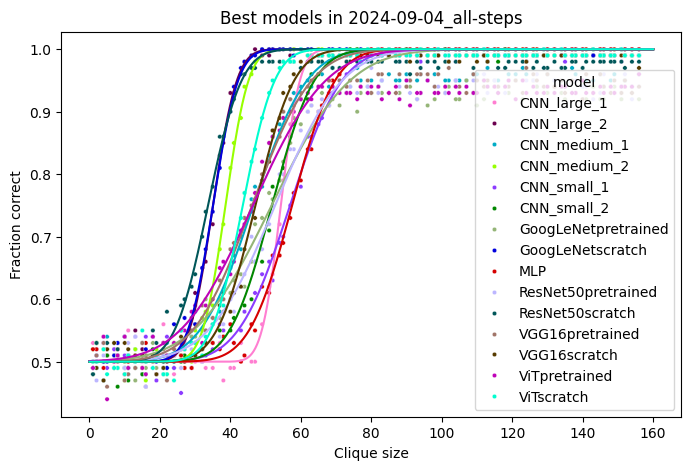

In [9]:
def draw_best_psychometrics(exp_name, my_palette=my_palette):
    """
    Draw and save psychometric curves for best models in the requested experiment.

    Parameters:
    exp_name (str): The name of the experiment.
    my_palette (dict): A dictionary associating a color to each model type.

    Returns:
    None
    """
    
    # FITTING THE DATA
    all_fitted_params = calculate_fitted_params(exp_name)
    
    # - filtering the fitted parameters to keep only the models where k0<150
    fitted_params_df = all_fitted_params[all_fitted_params['k0'] < 150]   # FILTERING
    # fitted_params_df = all_fitted_params    # NO FILTERING
      
    # RETRIEVING THE DATA
    # - go to exp results folder:
    folder_path = os.path.join('..','results', 'data', exp_name)
    # - isolate folders corresponding to best models
    filtered_folders = [folder_name for folder_name in os.listdir(folder_path) if folder_name in fitted_params_df['model'].values]
    # - create an empty dataframe to store the results and populate it with the data
    results_df = pd.DataFrame()
    models_names = []
    for folder_name in filtered_folders:
        models_names.append(folder_name)
        file_path = os.path.join(folder_path, folder_name, f'{folder_name}_N224_fraction_correct.csv')
        if os.path.isfile(file_path):
            df_result = pd.read_csv(file_path)
            df_result['model'] = folder_name
            results_df = pd.concat([results_df, df_result], ignore_index=True)

    # SELECTING THE RIGHT PALETTE
    my_palette_filtered = {key: my_palette[key] for key in models_names}
    
    # DRAWING THE PSYCHOMETRIC CURVES
    fig, ax = plt.subplots(figsize=(8, 5))

    # defining x values
    x_vals = np.linspace(0, 160, 1000)

    # Scatter plot based on unique dataframe:
    sns.scatterplot(data=results_df, x='clique size', y='fraction correct', hue='model', palette=my_palette_filtered, ax=ax, s=10)

    # defining y values and plotting the psychometric curves
    for model in models_names:
        model_df = fitted_params_df[fitted_params_df['model'] == model]
        k0 = model_df['k0'].values[0]
        delta = model_df['delta'].values[0]
        y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
        ax.plot(x_vals, y_vals, color=my_palette_filtered[f'{model}'], label=f'{model}')

    # setting labels and title
    ax.set_ylabel("Fraction correct")
    ax.set_xlabel("Clique size")    
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_title(f"Best models in {exp_name}")

    # saving figure in corresponding "plots" folder
    fig.savefig(os.path.join('..','results','plots', exp_name, f'best_models_fc_over_n_{exp_name}'), dpi=300)

    # Show the plot
    plt.show()

# example of use:
draw_best_psychometrics('2024-09-04_all-steps')   # CHANGE THIS

# $K_0$ comparison graph

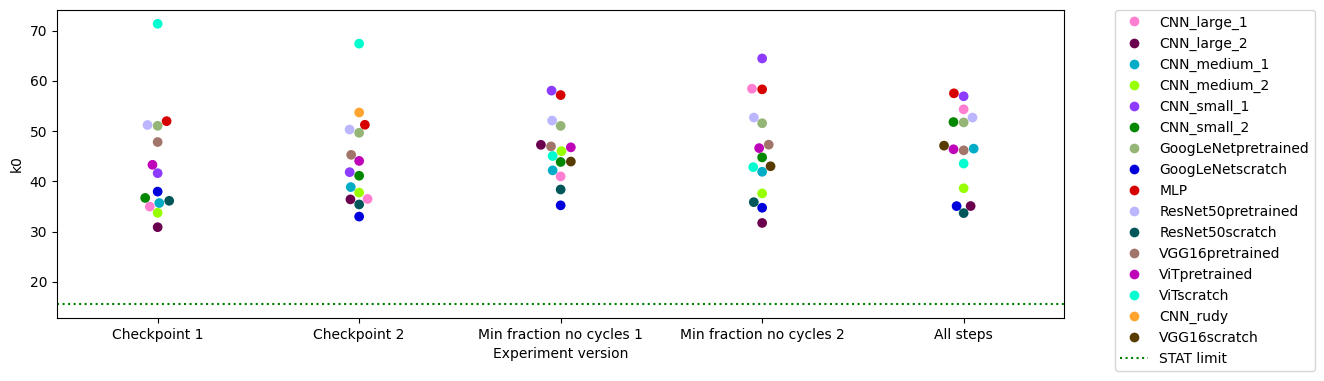

In [10]:
def k_0_comparison(*exp_names):
    """
    Draw and save a plot comparing the k0 values of the best models in the requested experiments.

    Parameters:
    *exp_names (str): Variable number of experiment names.

    Returns:
    None
    """

    fitted_params_comparison = pd.DataFrame()
        
    for exp_name in exp_names:
        # FITTING THE DATA
        all_fitted_params = calculate_fitted_params(exp_name)
        
        # - filtering the fitted parameters to keep only the models where k0<150
        fitted_params_df = all_fitted_params[all_fitted_params['k0'] < 150]
        
        # giving a more readable name to the experiments:
        if exp_name == '2024-06-20_short-exp':
            exp_name = 'Short exp 1'
        elif exp_name == '2024-06-26_long-exp':
            exp_name = 'Long exp 1'
        elif exp_name == '2024-07-10_short-exp':
            exp_name = 'Short exp 2'
        elif exp_name == '2024-07-11_long-exp':
            exp_name = 'Long exp 2'
        elif exp_name == '2024-07-17_mix-graphs':
            exp_name = 'Mix graphs 1'
        elif exp_name == '2024-08-05_mix-graphs':
            exp_name = 'Mix graphs 2'  
        elif exp_name == '2024-08-07_checkpoint':
            exp_name = 'Checkpoint 1'
        elif exp_name == '2024-08-08_checkpoint':
            exp_name = 'Checkpoint 2' 
        elif exp_name == '2024-08-19_sgd-no-momentum':
            exp_name = 'SGD no momentum'
        elif exp_name == '2024-08-20_sgd-momentum':
            exp_name = 'SGD momentum'      
        elif exp_name == '2024-08-29_min-fraction-no-cycles':
            exp_name = 'Min fraction no cycles 1'
        elif exp_name == '2024-09-02_min-fraction-no-cycles':
            exp_name = 'Min fraction no cycles 2'
        elif exp_name == '2024-09-04_all-steps':
            exp_name = 'All steps'
        else:
            raise ValueError("The experiment name is not valid.")
        
        # - adding the experiment name to all columns of the dataframe:
        fitted_params_df = fitted_params_df.copy()
        fitted_params_df['exp_name'] = exp_name
        
        # - concatenating the dataframes
        fitted_params_comparison = pd.concat([fitted_params_comparison, fitted_params_df], ignore_index=True)
    
    # Create a large figure
    plt.figure(figsize=(13, 4))

    # Use sns.swarmplot directly for a simpler approach
    ax = sns.swarmplot(data=fitted_params_comparison, x="exp_name", y="k0", hue="model", palette=my_palette, size=7)

    # Draw the statistical limit line
    plt.axhline(y=2*np.log2(224), color='g', linestyle=':')

    # Adjust legend to include the statistical limit line
    handles, labels = ax.get_legend_handles_labels()
    # Append the statistical limit line handle and label
    handles.append(plt.Line2D([], [], color='g', linestyle=':', label='STAT limit'))
    labels.append('STAT limit')

    # # Move the second-to-last entry (before adding STAT limit) to the third position
    # second_to_last_handle = handles[-2]  # Get the second-to-last handle
    # second_to_last_label = labels[-2]    # Get the second-to-last label
    # # Remove the second-to-last entries
    # del handles[-2]
    # del labels[-2]
    # # Insert them at the third position
    # handles.insert(2, second_to_last_handle)
    # labels.insert(2, second_to_last_label)

    # Set x label:
    ax.set_xlabel('Experiment version')
    
    # Create the legend with the adjusted handles and labels
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Saving figure
    plt.savefig(os.path.join('..', 'results', 'plots', 'comparison', 'K0_comparison_all_experiments.png'), dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()
  
# example of use:
k_0_comparison("2024-08-07_checkpoint", "2024-08-08_checkpoint", "2024-08-29_min-fraction-no-cycles", "2024-09-02_min-fraction-no-cycles", "2024-09-04_all-steps")   # CHANGE THIS